# K-Means
### Using libraries : $\textit{sklearn}$

## Imports

In [2]:
from utilities.std_imports import *
import pylab as pl
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans as KMeansGood
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.datasets.samples_generator import make_blobs

## KMeans

In [3]:
class KMeans(BaseEstimator):
    def __init__(self, k, max_iter=100, random_state=0, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        self.labels_ = euclidean_distances(X, self.cluster_centers_, squared=True).argmin(axis=1)

    def _average(self, X):
        return X.mean(axis=0)

    def _m_step(self, X):
        X_center = None
        for center_id in range(self.k):
            center_mask = self.labels_ == center_id
            if not np.any(center_mask):
                if X_center is None:
                    X_center = self._average(X)  # The centroid of empty clusters is set to the center of everything
                self.cluster_centers_[center_id] = X_center
            else:
                self.cluster_centers_[center_id] = self._average(X[center_mask])

    def fit(self, X, y=None):
        n_samples = X.shape[0]
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.labels_ = random_state.permutation(n_samples)[:self.k]
        self.cluster_centers_ = X[self.labels_]

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()
            self._e_step(X)
            self._m_step(X)
            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata: break
        return self

## K-Medians

In [4]:
class KMedians(KMeans):
    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)

    def _average(self, X):
        return np.median(X, axis=0)

## Fuzzy Means

In [5]:
class FuzzyKMeans(KMeans):

    def __init__(self, k, m=2, max_iter=100, random_state=0, tol=1e-4):
        # m > 1: fuzzy-ness parameter. The closer to m is to 1, the closter to hard kmeans. The bigger m, the fuzzier (converge to the global cluster).  
        self.k = k
        assert m > 1
        self.m = m
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        D = 1.0 / euclidean_distances(X, self.cluster_centers_, squared=True)
        D **= 1.0 / (self.m - 1)
        D /= np.sum(D, axis=1)[:, np.newaxis]
        # shape: n_samples x k
        self.fuzzy_labels_ = D
        self.labels_ = self.fuzzy_labels_.argmax(axis=1)

    def _m_step(self, X):
        weights = self.fuzzy_labels_ ** self.m
        # shape: n_clusters x n_features
        self.cluster_centers_ = np.dot(X.T, weights).T
        self.cluster_centers_ /= weights.sum(axis=0)[:, np.newaxis]

    def fit(self, X, y=None):
        n_samples, n_features = X.shape
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.fuzzy_labels_ = random_state.rand(n_samples, self.k)
        self.fuzzy_labels_ /= self.fuzzy_labels_.sum(axis=1)[:, np.newaxis]
        self._m_step(X)

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()
            self._e_step(X)
            self._m_step(X)
            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata: break
        return self

## Testing

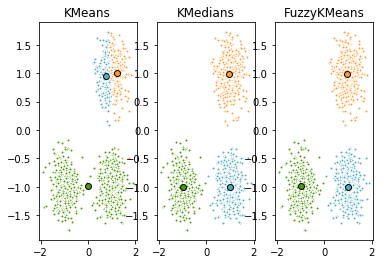

In [6]:
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=1200, centers=centers, cluster_std=0.3)

kmeans = KMeans(k=3)
kmeans.fit(X)

kmedians = KMedians(k=3)
kmedians.fit(X)

fuzzy_kmeans = FuzzyKMeans(k=3, m=2)
fuzzy_kmeans.fit(X)

fig = pl.figure()
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

objects = (kmeans, kmedians, fuzzy_kmeans)

for i, obj in enumerate(objects):
    ax = fig.add_subplot(1, len(objects), i + 1)
    for k, col in zip(range(obj.k), colors):
        my_members = obj.labels_ == k
        cluster_center = obj.cluster_centers_[k]
        ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
        ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
    ax.set_title(obj.__class__.__name__)

pl.show()